In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import create_map_function

# Data Set and Motivation

Since the mid-1980s the amount spent on political elections by campaigns and outside groups, measured by the Federal Election Committee, has grown by 555 percent nationwide. While voting ultimately determines the result of any given election, analyzing political contributions can signal how passionate and invested individuals are in the success of a given candidate. In this report we will assess the political climate in Colorado through focusing on individual campaign finance contributions from 1992 through 2016.  

The data used in this report is from the Center for Responsive Politics (CRP), an independent and nonprofit research group that collects political finance data. All 50 states require disclosures to be filed as a means of transparency and as a means to regulate money spent in elections. These disclosures are filed through the Federal Election Committee (FEC), the independent regulatory agency charged with administering and enforcing federal campaign finance law. The CRP uses public FEC fillings as the source for their data. The metadata used in this report can be found in the link below:
https://www.opensecrets.org/resources/datadictionary/UserGuide.pdf

Our report will utilize two data tables accross seven political cycles. The first table is individual contribution data, which includes 23 attributes including contribution amounts and political affiliation of recipient. Additionally, we will utilize the candidate table which includes 12 attributes and provides all candidites who recieved contributions in a given cycle. Samples of the two tables will be shown in subsequent pages. 

# Actual Task and Research Questions

The political landscape of Colorado has evolved rapidly over the last quarter century. While once a solidly conservative state, Colorado’s changing culture and influx of new residents from other regions has shifted Colorado’s politics more progressive. As shown in the chart below, both houses of Colorado's state assembly were typically controlled by Republicans from 1992 through the mid 2000's. However, since the late 2000's through 2013, Democrats have controlled both houses in addition to the Governer's seat. 



<img src="screen_shots/col_political_trends chart.png">
*Source: https://ballotpedia.org/Colorado_General_Assembly*

We set out to use campaign finance data to observe how these trends over the last 25 years have affected how Coloradans contribute to political campaigns by considering the following research questions:
* What trends exist in magnitude of money given, number of donations and political affiliation?
* Is there a relationship between the amount of money donated and candidate success in elections?
* How have political contributions evolved in different regions of the state?

# Data Cleaning
    - used %%script false to not run certain code blocks

We were able to download each year’s datasets from the website; however, the datafiles were too big to upload into GitHub. The first step in our data cleaning process was to convert the datafiles into a more compact form to allow us to upload all the data into our GitHub repository. We decided to convert the data text files into pickle files. Since each campaign year contained the same four datafiles, we created four functions in our CleanUP.py code, to read in the corresponding text files into a pandas data frame to clean up and then convert the cleaned data frame into a pickle file. When reading in each text file to convert to a data frame, we had to generate our own delimiter since the text files were not separated by commas.

In [ ]:
# Example of the uncleaned individuals 1992 file
! head indivs92.txt

The individuals text file was the largest of the datafiles. Since we only wanted to focus on the state of Colorado, once the text file was read in and converted into a data frame, we only pulled out the individuals that matched with ‘CO’ in the State column. This made it faster to clean the data frame because not all the data separated into their respective columns. The amount and date columns were still grouped with the RealCode column values. Once the original data frame was created, we had to then separate those columns. Then we were able to put the data frame into a pickle file.

In [ ]:
# Example of the dataframe of the cleaned individuals 1992 file
df = pd.read_pickle('analysis_of_crp_data/data/CampaignFin92/indivs92.pkl')
df

From the pacs text file not all the data separated into their respective columns either. The amount, date, and RealCode columns were still grouped with the CID column values. Once the original data frame was created, we had to then separate those columns. Then we were able to put the data frame into a pickle file.

The candidates text file generated a data frame that was separated correctly once the file was read in. Two symbols had to be removed from each of the end columns. Then we were able to put the data frame into a pickle file.

The pac to pac text file had many inconsistent missing values, this made it difficult to find the correct separator that would not raise a value error of length of rows not equal with one another. Since the pac to pac data files contained many unfilled values, we decided not to use this data and focus on the larger individuals data set along with the candidates and pacs.

We then were able to upload the three pickle files from each year to our GitHub repository. We took those pickle files to read in and convert into data frames. We compiled those data frames to create a complete individuals data frame and a candidates data frame of all the years.

The individuals data frame consisted of only Colorado. We still had to pull out the candidates from Colorado. The data frame had an Orgname column with values where the first two characters were the state and the last two characters represent the office sought for. We pulled out the candidates that contained ‘CO’ in that column.

In [ ]:
%%script false
cand_df.DistIDRunFor.str.contains('CO')
candCO_df = cand_df.loc[cand_df.DistIDRunFor.str.contains('CO')]
candCO_df.index = np.arange(len(candCO_df))

In [ ]:
%%script false
# Convert column to string remove duplicate information, 'CO' and party in Win/Loss column
candCO_df.loc[:,'DistIDRunFor'] = candCO_df.loc[:,'DistIDRunFor'].astype(str)
candCO_df.loc[:,'DistIDRunFor'] = candCO_df.loc[:,'DistIDRunFor'].apply(lambda x: pd.Series(str(x).replace('CO','')))
candCO_df.loc[:,'WinLoss'] = candCO_df.loc[:,'WinLoss'].apply(lambda x: pd.Series(str(x).replace(x[:1],'')))

In order to run visualizations on the individuals of Colorado data frame, we had to change the Amount column datatype from an object to an integer so we could perform statistic summarys on it.

In [ ]:
%%script false
# change the dtype of Amount from object to integer
indivs_df['Amount'] = indivs_df['Amount'].apply(lambda x: int(x))

The RecipCode column in the individuals data frame contained the party the individual contributed to and if that candidate won or loss. To pull out this information we first had to assign None to missing values in the RecipCode column.

In [ ]:
%%script false
import re

for i in range(len(indivs_df['RecipCode'])):
    att1 = re.search(r'[A-Z]|[0-9]',str(indivs_df.RecipCode[i]))
    if att1 == None:
        indivs_df.RecipCode[i] = None

Once there were no missing values, we were able to split the RecipCode into two columns since the value was two characters, Party and Result. We pulled out the first character which represented the party, it was either a capital letter or a number and the second character was assigned to the result column. If there was no second character, then NaN was assigned.

In [ ]:
%%script false
# split the RecipCode 
sub_df = indivs_df['RecipCode'].apply(lambda x: re.findall('[A-Z]|[0-9]',str(x)))

# create a new df with Party and Result column and add values to them
df= pd.DataFrame(columns=['Party','Result'])
df['Party'] = sub_df.apply(lambda x: x[0])

result = []
for i in sub_df:
    if len(i) < 2:
        result.append(np.nan)
    else:
        result.append(i[1])
df['Result'] = result

indivs_df['RecipCode']=df['Party']
indivs_df.insert(14,'Results',df['Result'])
indivs_df = indivs_df.rename(columns={'RecipCode':'Party'})

# Data Visualizations

In [250]:
#Load data files and combine into one df
indiv = pd.read_pickle('indivs.pkl')
indiv16 = pd.read_pickle('indivs16.pkl')
frames = [indiv,indiv16]
indivDF = pd.concat(frames,ignore_index=True)

In [233]:
cand_df = pd.read_pickle('cand_df_ALL.pkl')

For our first visualization and initial look at the individual contributions data, we will graph the number of individual contributions made through the cycle years. For purposes of the visualization we dropped the unkown and PAC contribution data. We noted just two instances of unknown party with a total dollar value of $550. Further, PAC data was dropped to get a better idea of just individual contributions to candidates. Moreover, the 'other independent' and 'other' parties were group together to aid in the readability of the visual. 

In [234]:
indivDFnoPac = indivDF.loc[np.logical_and.reduce((indivDF.Party != 'U', indivDF.Party != 'P'))]
indivDFnoPac.replace({'Party': {'3': 'I/O', 'O': 'I/O'}}, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


Initaial look at size of contributions for each party for all years. 

In [235]:
indivDFnoPac.groupby('Party').size()

Party
D      405266
I/O      8008
R      179833
dtype: int64

Text(0.5, 1.0, 'Number of Individual Contributions')

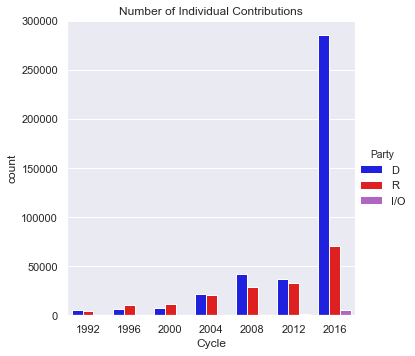

In [5]:
sns.set(style="darkgrid")
colors=['blue','red','mediumorchid']
sns.catplot(x='Cycle',hue='Party',palette=colors,kind="count", \
            data=indivDFnoPac)
plt.title('Number of Individual Contributions')

Here we can clearly note several trends in our data. Most noteably, the substantial increase in individual contributions in the 2016 cycle, particularly in the Democratic party. Further, we can note that both the 1996 and 2000 cycles more Rebublican contributions were made than Democratic contributions. This then shifts to more Democratic contributions in subsequent years. 

Because of the dramatic increase in contributions in 2016, we will investigate this further.

Alternatively, we can look at the total amounts contributed opposed to the number of individual contributions.

In [40]:
amountDF = indivDFnoPac.loc[np.logical_and.reduce((indivDFnoPac.Party != 'U', indivDFnoPac.Party != 'P'))]\
.groupby(['Cycle','Party'],as_index=False)['Amount'].sum()

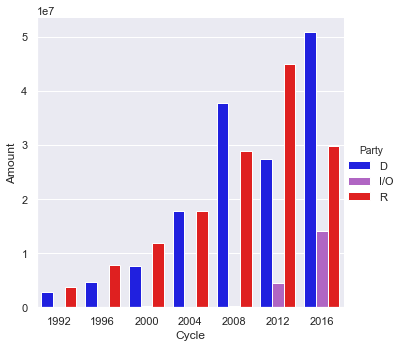

In [41]:
colors=['blue','mediumorchid','red']
sns.catplot(x='Cycle',y= 'Amount',hue='Party',palette=colors,kind="bar", \
            data=amountDF)

This gives us a much different picture than the total contributions graph above. It would seem that Rebulicans contribute more on average than Democrats do. We will confirm this below.  

Text(0.5, 1.0, 'Average Individual Contributions')

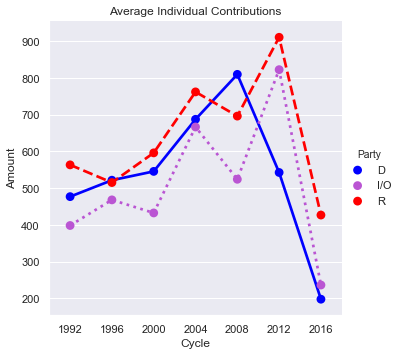

In [182]:
colors=['blue','mediumorchid','red']
sns.catplot(x="Cycle",y= 'Amount',hue='Party',palette=colors,kind="point",data=winloss1,linestyles=['-',':','--'])
plt.title('Average Individual Contributions')

The plot above shows average contributions by party for each cycle. While, 1996 and 2008 saw average contributions for the Democratic party exceed that of the Republican party, on average Republican contributions exceed that of Democrats. We can also note that the previous two election cycles, this gap has grown. 

Based on these plots we can see a trend toward a larger amount of lower dollar amounts being contributed to Democratic candidates. The same trend can be seen in the Republican party, although the decrease is not quite as substantial. This tells us that in the last two cycles more individuals are involved in politics, not just those who can afford to make large contributions. 

We have excluded the PAC data in the above analysis, however we will invetigate where this portion of contributions is going. 

In [121]:
pacDF = indivDF[indivDF.Party == 'P']

Text(0.5, 1.0, 'Individual Contributions to PACs')

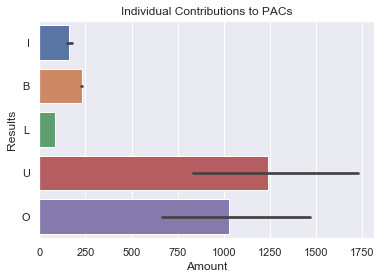

In [122]:
label=['Ideological','Business','Labor','Unknown','Other']
sns.barplot(x='Amount',y= 'Results', data=pacDF)
plt.title('Individual Contributions to PACs')

Note that individual contributions toward PACs is a small fraction of the total contributions made to individual candidates. As such, we have included all years in the analysis and looked at the affiliation of the PACs, i.e. what causes do they support. Unfortunalty, the graph above does not shed much light onto this question as the largest amounts are contributions to unknown and other categories. 

Now, we will look at how contributions are correlated to the success of the candidate. 

In [42]:
winloss = indivDF.loc[np.logical_and.reduce((indivDF.Party != 'U', indivDF.Party != 'P',indivDF.Results != 'I',indivDF.Results != 'N',indivDF.Results != 'P',indivDF.Results != 'C',indivDF.Results != 'O',indivDF.Results != 'K',indivDF.Results != 'B',indivDF.Results != 'U'))]\
.groupby(['Cycle','Party','Results'],as_index=False)['Amount'].sum()

Text(0.5, 1.0, 'Individual Contributions and Results')

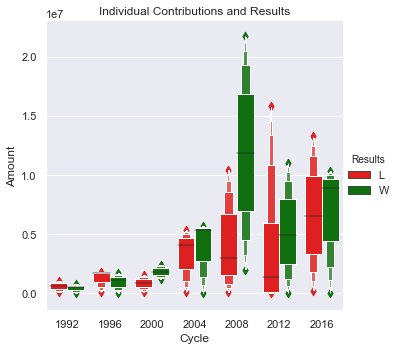

In [43]:
colors=['red','green']
sns.catplot(x='Cycle',y= 'Amount',hue='Results',palette=colors,kind="boxen", \
            data=winloss)
plt.title('Individual Contributions and Results')

With the large range in amounts donated, the boxen plot captures more quantiles than that of the standard box plot, thus giving a clearer picture of the distributution, particularly in the the tails. 

We note from this plot several trends, first, as contributions have increased through election cycles the correlation between winning and recieving more contributions is stronger. We note that the median amount of money recieved for the winning candidate is higher than that of the losing candidate in all years subsequent to year 2000.  

Note that in order to produce this plot we dropped several categories, which may distort the results. These categories in the results column include "I" for incumbent, "C" for Challenger, "O" for "Open Seat", and "N" for Non-incumbent. These were required to be removed as win loss data was not recorded for these groups in the data. Additionally, all PAC codes were reomved.  


Let's take another look at the win loss data this time accross party lines. 

In [125]:
winlossGross = indivDF.loc[np.logical_and.reduce((indivDF.Party != 'U', indivDF.Party != 'P',indivDF.Results != 'I',indivDF.Results != 'N',indivDF.Results != 'P',indivDF.Results != 'C',indivDF.Results != 'O',indivDF.Results != 'K',indivDF.Results != 'B',indivDF.Results != 'U'))]\
.groupby(['Party','Results'],as_index=False)['Amount'].sum()

Text(0.5, 1.0, 'Individual Contributions and Results')

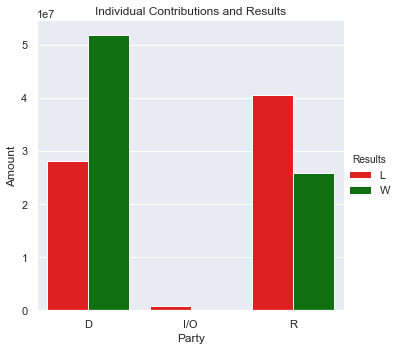

In [126]:
colors=['red','green']
sns.catplot(x='Party',y= 'Amount',hue='Results',palette=colors,kind="bar", \
            data=winlossGross)
plt.title('Individual Contributions and Results')

Here we can see the total contributions accross party lines and disaggregated by winning and losing campaigns. Interestingly, in the Republican party, more money has been contributed toward losing campaigns, whereas for the Democrats, the opposite is true. 

# Political Contributions by Party for each Zip Code

<img src="screen_shots/colorado_map.png">